In [14]:
### Aim of this notebook is to recreate Fig3 from the paper
### https://www.sciencedirect.com/science/article/pii/S0893608020303117
### and make it a test for our setup for future development.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# TODO: move to tests when plots will be working

In [15]:
N = 300
P = 300

In [16]:
alpha=P/N
print("alpha is {}".format(alpha))

alpha is 1.0


In [17]:
sgm_w = 1
sgm_e = np.sqrt(1/5)  # to ensure SNR=5
sgm_w0 = 0 

In [18]:
SNR=sgm_w**2/sgm_e**2
print("SNR is {}".format(SNR))

SNR is 5.0


In [215]:
phases=['train','valid']

In [216]:
### TEACHER
def generate():
    Y, X, eps = {}, {}, {}
    w_bar = np.random.normal(0, sgm_w, N)
    for phase in phases:
        X[phase] = np.random.normal(0, np.sqrt(1/N), [P, N])
        eps[phase] = np.random.normal(0, sgm_e, P)

        Y[phase] = X[phase] @ w_bar + eps[phase]
    return X,Y

In [217]:
### STUDENT
W0 = np.random.normal(0, sgm_w0, N)
def student(x, w):
     return x @ w

In [421]:
epochs=100
lr=1e-2
tau=1

In [425]:
def MP_evals(P, N):
    x = np.random.normal(size=(P, N))
    eVals, _ = np.linalg.eigh(np.corrcoef(x, rowvar=0))
    idx = eVals.argsort()[::-1]  # arguments for sorting eVal desc
    return eVals[idx]

eVals=MP_evals(P,N)

def analytical(t):
    A0 = (sgm_w**2 + sgm_w0**2)
    A = lambda t: A0*np.exp(-2 * eVals* t/tau)
    B0= 1/eVals * sgm_e**3
    B = lambda t: B0*(1 - np.exp(-eVals * t/tau))**2
    eg11= 1 / N * np.sum(A(t) + B(t)) + sgm_e**2
    return eg11

timesteps=np.linspace(0, epochs, 100)
e_g11 = np.array([analytical(_t) for _t in timesteps])

In [429]:
   
n_run=100

w=W0.copy()
for n in range(n_run):
    history={k:[] for k in phases}   
    X, Y = generate()
#     plt.hist(X['train'])

    for epoch in range(1,epochs+1):
#         print("EPOCH {}".format(epoch))
        running_grad=0.0
        for phase in phases:
            running_loss=0.0
#             print("PHASE {}".format(phase))
            for x, y in zip(X[phase],Y[phase]):
                y_tru=y
                y_pred=student(x, w)
                running_loss+=(y_tru-y_pred)**2
                if phase=='train':
                    running_grad+= -2*(y_tru-y_pred)*x
            loss=running_loss/P
#                 if epoch==1 and phase=='train': ### DEBUG
#                     print("LOSS", loss)
            grad=running_grad/P
            if phase=='train':
                w-=lr*running_grad
            history[phase].append(loss)
    var_t=[x**2 for x in np.array(history['train'])]
    var_v=[x**2 for x in np.array(history['valid'])]
    if n==0:
        training = np.array(history['train'])
        validate = np.array(history['valid'])
        tr_var = np.array(var_t)
        val_var = np.array(var_v)
    else:
        training += np.array(history['train'])
        validate += np.array(history['valid'])
        tr_var += np.array(var_t)
        val_var += np.array(var_v)

### AVERAGING OVER REALISATIONS
training/=n_run
validate/=n_run
tr_var/=n_run
val_var/=n_run
tr_var-=training**2
val_var-=validate**2


In [430]:
### ASSERTING INITIAL VALUES WITHIN THE THEORETICAL PREDICTION
theor_0=sgm_w0**2 +sgm_w**2+sgm_e**2
tr_0=training[0]
val_0=validate[0]
# assert (tr_0-theor_0)**2 < 1e-2   
# assert (val_0-theor_0)**2 < 1e-1

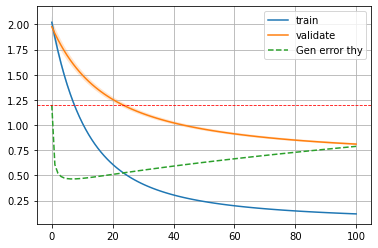

In [434]:
plt.plot(np.linspace(0,epoch,epoch),training, label='train')
plt.fill_between(np.linspace(0,epoch,epoch),training - tr_var, training + tr_var, alpha=0.2)

plt.plot(np.linspace(0,epoch,epoch),validate, label='validate')
plt.fill_between(np.linspace(0,epoch,epoch),validate - val_var, validate + val_var, alpha=0.2)
plt.plot(timesteps, e_g11,linestyle='--', label='Gen error thy')
# plt.ylim([0,1.5])
plt.grid()
plt.axhline(y=sgm_w0**2 +sgm_w**2+sgm_e**2, color='r', linestyle='--',  linewidth=0.8) 
plt.legend()
plt.show()